 This is the best model for Llama 7B

In [1]:
from transformers import AutoTokenizer
data_path = "data/llama/7B_NoQuant_FT_cl_1epoch/maxNewTokensFactor8_nShotsInference0_llama-2-7b-chat-hf_adapters_en.layer1_NoQuant_torch.bfloat16_16_16_0.02_1_0.0002_clent.csv" #"data/llama/7B_NoQuant_FT/maxNewTokensFactor8_nShotsInference0_llama-2-7b-chat-hf_adapters_en.layer1_NoQuant_torch.bfloat16_16_32_0.01_2_0.0002.csv"
apadpetrs_checkpoint = "ferrazzipietro/Llama-2-7b-chat-hf_adapters_en.layer1_NoQuant_torch.bfloat16_16_16_0.02_1_0.0002_clent" # "ferrazzipietro/llama-2-7b-chat-hf_adapters_en.layer1_NoQuant_torch.bfloat16_16_32_0.01_2_0.0002"

In [38]:
import json
import re
from typing import Tuple
from typing import List
from datasets import Dataset
import pandas as pd
from fuzzywuzzy import fuzz
from transformers import AutoTokenizer
import string

class OutputAnalist():
    def __init__(self, data, verbose=False) -> None:
        self.verbose = verbose
        self.data = data
        self.counter_dict = {
            'perfect_output':0,
            'is_empty_list':0,
            'is_list_of_lists':0,
            'is_list_of_dicts':0,
            'is_list_of_lists_and_dict':0,
            'is_list_of_strings':0,
            'is_list_of_empty_dict':0,
            'is_list_with_one_empty_dict':0,
            'is_list_of_dicts_with_empty_lists':0,
            'is_list_of_dicts_with_one_key_multiple_values':0,
            'is_list_of_dicts_with_multiple_keys_included_entity':0,
            'is_list_of_dict_numeric_values':0,
            'is_list_of_dicts_none_values':0,
            'is_list_of_dicts_and_strings':0,
            'is_list_of_dicts_and_lists_of_strings':0,
            'is_list_of_dicts_with_value_list':0,
            'is_string':0,
            'is_list_of_strings_representing_dicts':0,
            'is_list_of_dicts_of_lists':0,
            'is_numeric':0,
            'are_entities_extracted_as_dict_keys_instead_of_values':0,
            'uknown':0
        }
  
    def _remove_space_from_dict_keys(self, model_ouput_list: list) -> list:
        """
        Remove the spaces from the keys of a dictionary. E.g., [{"entity ": "value"}] -> [{"entity": "value"}]

        Args:
        model_ouput_list (dict): the list of dictionaries to be cleaned

        return:
        list: the cleaned list of dicts
        """
        out = []
        for dict in model_ouput_list:
            # print('DICT: ', dict)
            out.append({k.replace(' ', ''): v for k, v in dict.items()})
        return out
    
    def _drop_duplicates(self, model_response: list) -> str:
        """
        Drop the duplicates from a list. This is useful when the model output contains the same entity multiple times.

        Args:
        model_response (str): the model response with no duplicates
        """
        # print('DROPPING DUPLICATES: ', model_response)
        try :
            return list({v['entity']:v for v in model_response}.values())
        except Exception as error:
            model_response = self._remove_space_from_dict_keys(model_response)
            # print('ERROR: ', model_response)
            return list({v['entity']:v for v in model_response}.values())
        
    def _assess_model_output(self, model_response: str) -> bool:
        """
        Check if the model output is in the right format. If not, return False.
        
        Args:
        model_output (str): the postprocessed model output after beeing passed to _postprocess_model_output()

        return:
        bool: True if the format is correct, False otherwise
        """
        good_format = True
        try :
            res = json.loads(model_response)
            # print( res)
        except:
            good_format = False
        return good_format

            
    def _remove_json_special_chars(self, string):
        """
        Remove the special characters from a string. This is useful when the model output contains special characters that are not allowed in the json format.
        """
        # print('sto pulendo: ', string)
        chars = ['\xa0', '\x80', '\x93', '\U00100000', '\r\n', '\U00100000I', '\\u001d', '\\"']
        for char in chars:
            string = string.replace(char, ' ')
        char_no_space = ['\xad']
        for char in char_no_space:
            string = string.replace(char, '')
        string = string.replace('\\u0010', '^')
        return string
    
    
    def _clean_ground_truth(self, example: dict) -> dict:
        ground_truth = example['ground_truth']
        # print('inner ground truth: ', ground_truth)
        ground_truth = self._remove_json_special_chars(ground_truth)
        ground_truth = ground_truth.replace('</s>', '').replace('<|im_e', '').replace('<|end_of_text|>', '').replace('<|endoftext|>', '')
        return({'ground_truth': ground_truth})

    def _clean_model_output(self, example: dict,  wrong_keys_to_entity:bool, latest_version:bool=True) -> dict:
        """
        Postprocess the model output to return a json like formatted string that can be used to compute the F1 score.

        Args:
        model_output (str): the model output as it is returned by the model. The processing of the output is done in the function
        wrong_keys_to_entity (bool): if True, the function also extracts the dictionaries with keys different from 'entity', converting the keys into 'entity'. If not, all keys that are not 'entity' are dropped

        return:
        dict: the model response

        """
       
        def is_empty_list(string:str)  -> bool:
            if string=='[]':
                return True
            return False
        
        def is_list_of_lists(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, list) for item in tmp):
                    return True
            return False
        
        def is_list_of_dicts(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    return True
            return False
        
        def is_list_of_lists_and_dict(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                found_dict = False
                found_list = False
                for element in tmp:
                    if isinstance(element, list):
                        found_list = True
                    elif isinstance(element, dict):
                        found_dict = True
                    if found_list and found_dict:
                        return True
            return False
        
        def is_list_of_strings(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, str) for item in tmp):
                    return True
            return False

        def is_list_of_empty_dict(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                #print('TMP: ', tmp)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    if all(str(item) == "{}" for item in tmp):
                        return True
            return False

        def is_list_with_one_empty_dict(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list):
                    for item in tmp:
                        if item == {}:
                            return True
            return False
        
        def is_list_of_dicts_with_empty_lists(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        for v in item.values():
                            if v == []:
                                return True
            return False
        
        def is_list_of_dicts_with_one_key_multiple_values(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        if len(item) == 1 and len(item.values()) > 1:
                            return True
            return False

        def is_list_of_dicts_with_multiple_keys_included_entity(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        if len(item) > 1 and 'entity' in item.keys():
                            return True
            return False

        def is_list_of_dict_numeric_values(string:str)  -> bool:
            #print('STRING: ', string)
            if self._assess_model_output(string):
                tmp = json.loads(string)
                #print('TMP: ', tmp)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        if len(item.values()) > 0:
                            val = list(item.values())[0] 
                            if isinstance(val, int) or isinstance(val, float):
                                return True
            return False
        
        def is_list_of_dicts_none_values(string:str) -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        if len(item.values()) > 0:
                            val = list(item.values())[0] 
                            if val is None:
                                return True
            return False

        def is_list_of_dicts_and_strings(string:str)  -> bool:
            if self._assess_model_output(string):
                #print('ASSESSED')
                tmp = json.loads(string)
                found_dict = False
                found_string = False
                for element in tmp:
                    if isinstance(element, str):
                        found_string = True
                    elif isinstance(element, dict):
                        found_dict = True
                    if found_string and found_dict:
                        return True
            return False
        
        def is_list_of_dicts_and_lists_of_strings(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                # print('TMP: ', tmp)
                if isinstance(tmp, list):
                    if all(isinstance(item, dict) for item in tmp):
                        return False
                    for item in tmp:
                        # print('ITEM: ', item)
                        if isinstance(item, dict):
                            
                            if len(item.values()) == 0:
                               return False
                            if item.get('entity') is None:
                                return False
                        elif isinstance(item, list):
                            if len(item) != 1:
                                return False
                            if not isinstance(item[0], str):
                                return False
                        else:
                            return False
                    return True
            return False
        
        def is_list_of_dicts_with_value_list(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        for v in item.values():
                            if isinstance(v, list):
                                return True
            return False
        
        def is_string(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, str):
                    return True
            return False
        
        def is_list_of_strings_representing_dicts(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                # print('TMP: ', tmp)
                if isinstance(tmp, list) and all(isinstance(item, str) for item in tmp):
                    tmp_list = []
                    for item in tmp:
                        # print('ITEM: ', item)
                        if self._assess_model_output(item):
                          tmp_list.append(json.loads(item))
                    if all(isinstance(item, dict) for item in tmp_list):
                        return True
            return False
        
        def is_list_of_dicts_of_lists(string:str)  -> bool:
            # print('STRING: ', string)
            if self._assess_model_output(string):
                tmp = json.loads(string)
                # print('TMP: ', tmp)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    for item in tmp:
                        # print('item: ',item)
                        tmp2 = list(item.values())[0]
                        if len(tmp2) > 0:
                            if isinstance(list(item.values())[0], list):
                                return True
            return False
        
        def is_numeric(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, (int, float)):
                    return True
            return False
        
        def are_entities_extracted_as_dict_keys_instead_of_values(string:str, example:dict) -> bool:
            if is_list_of_dicts(string):
                tmp = json.loads(string)
                keys = [key for item in tmp for key in item.keys()]
                if 'entity' not in keys:
                    if all(entity in example['sentence'] for entity in keys):
                        return True
            return False
        
        
        
        def convert_wrong_keys_into_entity(string:str) -> List[str]:
            if is_list_of_dicts(string):
                tmp = json.loads(string)
                tmp = [str({"entity":v}) for el in tmp for v in el.values()]
                return tmp
            else:
                return []


        def only_dicts_with_key_entity(string:str, wrong_keys_to_entity:bool) -> Tuple[bool, str]:
            """
            Extract only the dictionaries with the key 'entity' in the list of dictionaries in the string
            
            Args:
            string (str): the string to be cleaned
            wrong_keys_to_entity (bool): if True, the function also extracts the dictionaries with keys different from 'entity', converting the keys into 'entity'
            """
            els_between_curly = re.findall(r'\{(.+?)\}', string)
            clean = [el for el in els_between_curly if el.startswith('"entity"') or el.startswith("'entity'")]
            clean = ['{' + el + '}' for el in clean]
            dirty = []
            if wrong_keys_to_entity:
                dirty = [el for el in els_between_curly if (not el.startswith('"entity"')) and (not el.startswith("'entity'"))]
                dirty = ['{' + el + '}' for el in dirty]
                dirty = '[' + ', '.join(dirty) + ']'
                cleaned_dirty = convert_wrong_keys_into_entity(dirty)
                out = '[' + ', '.join(clean) + ', '.join(cleaned_dirty) +  ']'
            else:
                out = '[' + ', '.join(clean) + ']'
            # out = out.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(" \'", " \"")
            operations_performed = False
            if len(clean) != len(els_between_curly):
                operations_performed = True
            if is_empty_list(out):
                return operations_performed, '[{"entity":""}]'
            return operations_performed, str(out)
        
        if self.verbose: print('EXAMPLE:  ', example['model_responses'])
        model_output = example['model_responses']
        if self.verbose: print('ORIGINAL MODEL OUTPUT:', model_output)
        # print('ORIGINAL MODEL OUTPUT:', model_output)
        if self.verbose: print('GROUND TRUTH: ', example['ground_truth'])
        # model_output = self._exceptions_handler(model_output)

        if is_list_of_dicts(model_output):
            self.counter_dict['perfect_output'] += 1
            if self.verbose: print('is_list_of_dicts')
            tmp = json.loads(model_output)
            return {'model_output':str(tmp)}
    
        if model_output is None or is_empty_list(model_output):
            return {'model_output':'[{"entity":""}]'}
        
        # model_output = self._special_cases_handler(model_output)
        model_output = self._remove_json_special_chars(model_output)
        if self.verbose:print('PULITO: ', model_output)

                
        if are_entities_extracted_as_dict_keys_instead_of_values(model_output, example):
            self.counter_dict['are_entities_extracted_as_dict_keys_instead_of_values'] += 1
            if self.verbose: print('ENTITIES EXTRACTED AS DICT KEYS INSTEAD OF VALUES')
            tmp = json.loads(model_output)
            tmp = [{"entity":k} for el in tmp for k in el.keys() ]
            tmp = str(tmp)
            return {'model_output':tmp}
        
        if is_list_of_dicts_and_lists_of_strings(model_output):
            self.counter_dict['is_list_of_dicts_and_lists_of_strings'] += 1
            if self.verbose: print('is_list_of_dicts_and_lists_of_strings')
            tmp = json.loads(model_output)
            out = []
            for item in tmp:
                if self.verbose: print('ITEM: ', item)
                if isinstance(item, dict):
                    out.append(item)
                elif isinstance(item, list):
                    out.append({"entity":item[0]})
            return {'model_output':str(out)}

        if is_numeric(model_output):
            self.counter_dict['is_numeric'] += 1
            # print('IS NUMERIC')
            return {'model_output':'[{"entity":""}]'}

        # print('QUI HO QUESTO: ', model_output)
        if is_list_of_strings_representing_dicts(model_output):
            self.counter_dict['is_list_of_strings_representing_dicts'] += 1
            if self.verbose: print('is_list_of_strings_representing_dicts 1')                
            tmp = json.loads(model_output)
            tmp_list = []
            for item in tmp:
                if self._assess_model_output(item):
                  tmp_list.append(json.loads(item))
            if self.verbose: print('TEMPOOOO 2 ',tmp)
            return {'model_output':str(tmp_list)}
        
        if is_list_of_dicts_with_one_key_multiple_values(model_output):
            self.counter_dict['is_list_of_dicts_with_one_key_multiple_values'] += 1
            if self.verbose: print('is_list_of_dicts_with_one_key_multiple_values')
            tmp = json.loads(model_output)
            tmp = [{"entity":v[0]} for el in tmp for v in el.values()]
            return {'model_output':str(tmp)}
       
        if is_list_of_dicts_with_multiple_keys_included_entity(model_output):
            self.counter_dict['is_list_of_dicts_with_multiple_keys_included_entity'] += 1
            if self.verbose: print('is_list_of_dicts_with_multiple_keys_included_entity')
            tmp = json.loads(model_output)
            out = []
            for item in tmp:
                if item.get('entity') is not None:
                    out.append({"entity":item.get('entity')})
            return {'model_output':str(out)}
        
        
        if is_list_of_lists_and_dict(model_output):
            self.counter_dict['is_list_of_lists_and_dict'] += 1
            if self.verbose: print('is_list_of_lists_and_dict')
            tmp = json.loads(model_output)
            for el in tmp:
                if isinstance(el, list):
                    tmp = str(el)
                    # print('is_list_of_lists_and_dict')
                    return {'model_output':tmp}
                
        if is_list_of_lists(model_output):
            self.counter_dict['is_list_of_lists'] += 1
            if self.verbose: print('is_list_of_lists')
            tmp = json.loads(model_output)
            tmp2 = str(tmp[0]).replace("'", "\"")
            if is_list_of_dicts_and_strings(tmp2):
                tmp = tmp[0]
                out = [item for item in tmp if isinstance(item, dict)]
                return {'model_output':str(out)} 
            tmp = str(tmp[0])
            return {'model_output':tmp}
        

        if is_list_of_strings(model_output):
            self.counter_dict['is_list_of_strings'] += 1
            if self.verbose: print('is_list_of_strings')
            tmp = json.loads(model_output)
            tmp = [{"entity":el} for el in tmp]
            tmp = str(tmp)
            # print('is_list_of_strings')
            if self.verbose: print('TEMPOOOO ',tmp)
            return {'model_output': tmp}
        
        if is_string(model_output):
            self.counter_dict['is_string'] += 1
            # model_output = model_output.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(" \'", " \"")
            if self.verbose: print('PULO: ', model_output)
            tmp = json.loads(model_output)
            if all(el in tmp for el in ['{', 'entity', '}']):
                return {'model_output':tmp}
            tmp = [{"entity":tmp}]
            tmp = str(tmp)
            #print('is_string')
            return {'model_output':tmp}

        
        if latest_version:
            model_output = self._extract_text_between_curl_brackets(model_output)
            model_output = self._clean_text_between_curl_brackets(model_output)

            # print('QUI HO il SECONDO QUESTO: ', model_output)

            if is_list_of_strings_representing_dicts(model_output):
                self.counter_dict['is_list_of_strings_representing_dicts'] += 1
                if self.verbose: print('is_list_of_strings_representing_dicts 2')                
                tmp = json.loads(model_output)
                tmp_list = []
                for item in tmp:
                    if self._assess_model_output(item):
                        tmp_list.append(json.loads(item))
                return {'model_output':str(tmp_list)}
            
            if is_list_of_dicts_with_one_key_multiple_values(model_output):
                self.counter_dict['is_list_of_dicts_with_one_key_multiple_values'] += 1
                if self.verbose: print('is_list_of_dicts_with_one_key_multiple_values')
                tmp = json.loads(model_output)
                tmp = [{"entity":v[0]} for el in tmp for v in el.values()]
                return {'model_output':str(tmp)}
            
            if is_list_of_dicts_and_lists_of_strings(model_output):
                self.counter_dict['is_list_of_dicts_and_lists_of_strings'] += 1
                if self.verbose: print('is_list_of_dicts_and_lists_of_strings')
                tmp = json.loads(model_output)
                out = []
                for item in tmp:
                    # print('ITEM: ', item)
                    if isinstance(item, dict):
                        out.append(item)
                    elif isinstance(item, list):
                        out.append({"entity":item[0]})
                return {'model_output':str(out)}
            
            if self.verbose: print('QUI HO il TEERZO QUESTO: ', model_output)

            if is_list_of_dicts_with_empty_lists(model_output):
                self.counter_dict['is_list_of_dicts_with_empty_lists'] += 1
                if self.verbose: print('is_list_of_dicts_with_empty_lists')
                tmp = json.loads(model_output)
                tmp = [{"entity":v} for el in tmp for v in el.values() if v != []]
                # print('TMP: ', tmp)
                if is_list_of_dicts_with_value_list(str(tmp).replace("'", "\"")):
                    if self.verbose: print('is_list_of_dicts_with_value_list')
                    tmp = [{"entity":v} for el in tmp for v in el.values() if not isinstance(v, list)]
                    tmp2 = [{"entity":v[0]} for el in tmp for v in el.values() if isinstance(v, list)]
                    # print('returning this: ', {'model_output ':str(tmp2)}  )
                    return {'model_output':str(tmp2)}
                # print('returning this: ', {'model_output ':str(tmp)}  )

                return {'model_output':str(tmp)}
            
            if self.verbose: print('QUI HO il QUARTO QUESTO:', model_output)

            if is_list_of_dicts_with_value_list(model_output):
                self.counter_dict['is_list_of_dicts_with_value_list'] += 1
                if self.verbose: print('is_list_of_dicts_with_value_list')
                tmp = json.loads(model_output)
                tmp = [{"entity":v} for el in tmp for v in el.values() if not isinstance(v, list)]
                tmp2 = [{"entity":v[0]} for el in tmp for v in el.values() if isinstance(v, list)]
                return {'model_output':str(tmp)}

            if is_list_of_dict_numeric_values(model_output):
                self.counter_dict['is_list_of_dict_numeric_values'] += 1
                if self.verbose: print('is_list_of_dict_int_values')
                tmp = json.loads(model_output)
                tmp = [str({"entity":str(v)}) for el in tmp for v in el.values()]
                model_output = str(tmp)
            
            if is_list_of_dicts_none_values(model_output):
                self.counter_dict['is_list_of_dicts_none_values'] += 1
                if self.verbose: print('is_list_of_dicts_none_values')
                tmp = json.loads(model_output)
                tmp = [str({"entity":v}) for el in tmp for v in el.values() if v is not None]
                model_output = str(tmp)
                    
            if is_list_of_empty_dict(model_output):
                self.counter_dict['is_list_of_empty_dict'] += 1
                if self.verbose: print('is_list_of_empty_dict')
                return {'model_output':'[{"entity":""}]'}
            
            if is_list_with_one_empty_dict(model_output):
                self.counter_dict['is_list_with_one_empty_dict'] += 1
                if self.verbose: print('is_list_with_one_empty_dict')
                tmp = json.loads(model_output)
                tmp = [el for el in tmp if el != {}]
                model_output = tmp
                return {'model_output':str(model_output)}
            
            if is_list_of_dicts_of_lists(model_output):
                self.counter_dict['is_list_of_dicts_of_lists'] += 1
                if self.verbose: print('is_list_of_dicts_of_lists')
                tmp = json.loads(model_output)
                tmp = [{"entity":v} for el in tmp for v in el.values() if not isinstance(v, list)]
                # tmp.extend([{"entity":el.values()[0]} for el in tmp if isinstance(el.values(), list)])
                # print('returning this: ', {'model_output ':str(tmp)}  )
                return {'model_output':str(tmp)}  
                
            if self.verbose: print('CLEANED: ', model_output)
            cleaning_done, cleaned_model_output = only_dicts_with_key_entity(model_output, wrong_keys_to_entity=wrong_keys_to_entity)
            if cleaning_done:
                model_output = cleaned_model_output
            
            if is_list_of_dicts(model_output):
                self.counter_dict['is_list_of_dicts'] += 1
                if self.verbose: print('PRE  CLEANED: ', model_output)
                if is_list_of_dicts_with_multiple_keys_included_entity(model_output):
                    self.counter_dict['is_list_of_dicts_with_multiple_keys_included_entity'] += 1
                    if self.verbose: print('is_list_of_dicts_with_multiple_keys_included_entity')
                    tmp = json.loads(model_output)
                    out = []
                    for item in tmp:
                        if len(item) > 1 and 'entity' in item.keys():
                            out.append({"entity":item.get('entity')})
                    return {'model_output':str(out)}
                tmp = json.loads(model_output)
                return {'model_output':str(tmp)}
            
            else: 
                self.counter_dict['uknown'] += 1
                # print('NOT CLEANED: ', model_output, '\n\n')
                return {'model_output':'[{"entity":""}]'}
        
            
    def _exceptions_handler(self, model_output: str, error) -> str:
        # if hasattr(error, 'msg'):
        #     if error.msg.startswith('Expecting property name enclosed in double quotes'):
        #         model_output = model_output.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
        
        try:
            json.loads(model_output)
        except Exception as error:
            if isinstance(error, json.decoder.JSONDecodeError):
                #if error.msg == "Expecting ',' delimiter":
                key_part, value_part = model_output.split(': ', 1)
                first_occurrence = value_part.find('"')
                last_occurrence = value_part.rfind('"')
                model_output = key_part + ': "' + value_part[first_occurrence+1:last_occurrence].replace("'", r'\'') + '"' + '}'
        return model_output
    # .replace("\'", " ")
    
    def _substitute_apexes(self, model_output: str) -> str:
        model_output = model_output.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
        return model_output
    
    
    def _extract_text_between_curl_brackets(self, model_output: str) -> str:
        """
        Extract the text between the curl brackets of the model output, as enities are usually outputted in this format: {"entity": "value"}

        Args:
        model_output (str): the example from the dataset

        """
        text_between_curl_brackets = re.findall(r'\{(.+?)\}', model_output)
        cleaned_output = ['{'+ el +'}' for el in text_between_curl_brackets]
        cleaned_output = '[' + ', '.join(cleaned_output) + ']'
        return cleaned_output
    

    def _clean_text_between_curl_brackets(self, text_between_curl_brackets: str) -> str:
        """
        Clean the text between the curl brackets of the model output, as entities are usually outputted in this format: {"key": "value"}

        Args:
        model_output (str): the example from the dataset

        """
        text_between_curl_brackets = re.sub(r'",(.+?)}', r'"}', text_between_curl_brackets)
        text_between_curl_brackets = re.sub(r'{},', r'', text_between_curl_brackets)
        text_between_curl_brackets = re.sub(r',{}', r'', text_between_curl_brackets)
        # print('CLEANED: ', text_between_curl_brackets)
        # text_between_curl_brackets = re.sub(r'\{"entity":\[\]\},', r'', text_between_curl_brackets)
        # text_between_curl_brackets = re.sub(r',{\'entity\':[]}', r'', text_between_curl_brackets)
        return text_between_curl_brackets
    
    def apply_cleaning(self, data, wrong_keys_to_entity) -> None:
        """
        Apply the cleaning to the model output and return the cleaned response in a new cloumn called 'model_output

        Args:
        data (list): the dataset containing the model output
        wrong_keys_to_entity (bool): if True, the function also extracts the dictionaries with keys different from 'entity', converting the keys into 'entity'. If not, all keys that are not 'entity' are dropped
        """
        data = data.filter(lambda example: example["entities"] is not None)
        data = data.map(lambda x: self._clean_ground_truth(x), remove_columns=['ground_truth'])
        data = data.map(lambda x: self._clean_model_output(x, wrong_keys_to_entity)) 
        self.data = data
        return data
    
    def get_examples_based_on_metric(self, metric, upper_threshold=1, lower_threshold=0):
        """
        Select the examples based on the metric and the threshold.
        Args:
        metric (str): the metric to consider
        threshold (float): the threshold to consider
        return:
        list: the list of examples that satisfy the condition
        """
        out = [example for example in self.data if example[metric] <= upper_threshold and example[metric] >= lower_threshold]
        return(Dataset.from_pandas(pd.DataFrame(out)))

    def create_allucinations_columns(self, data, verbose:bool=False):
        """
        Create two columns that contain the invented entities/hallucinations, which are spans of text that have been extracted but are not in the sentence.
        The first column ('light_allucinations') contains the invented entities that are similar to at least one entity in the sentence, while the second column ('heavy_allucinations') contains the invented entities that are not similar to the entities in the sentence.
       
        Args:
        data (list): the dataset containing the model output
        verbose (bool): default False. If True, print verbose
        """
        light_allucinations, heavy_allucinations = [], []
        for el in data:
            light_invented_entities = []
            heavy_invented_entities = []
            for extracted_entity in el['model_output_parsed']['entities']:
                if extracted_entity.lower() not in el['sentence'].lower():
                    if verbose: print(f"'{extracted_entity}' not in sentence...")
                    if len(extracted_entity.split())==1:
                        possible_entities = el['sentence'].split()
                    else:
                        n_words_in_entity= len(extracted_entity.split())
                        possible_entities = [' '.join(el['sentence'].split()[i:i+n_words_in_entity]) for i in range(len(el['sentence'].split())-(n_words_in_entity-1))]
                    if verbose: print(f'looking through {possible_entities}...')
                    similarities = [fuzz.ratio(extracted_entity, possible_similar_entity) > 80
                                    for possible_similar_entity in possible_entities]
                    if any(similarities):
                        if verbose: print('SIMILARITY FOUND', extracted_entity, '||||', el['sentence'].split()[similarities.index(True):similarities.index(True)+len(extracted_entity.split())])
                        light_invented_entities.append({'extracted_entity':extracted_entity, 'original_entity':el['sentence'].split()[similarities.index(True)], 'original_sentence':el['sentence']})  
                    else:
                        heavy_invented_entities.append({'extracted_entity':extracted_entity, 'original_sentence':el['sentence']})
                    if verbose: print('\n')

            light_allucinations.append(light_invented_entities)
            heavy_allucinations.append(heavy_invented_entities)
        data = data.add_column('light_allucinations', light_allucinations)
        data = data.add_column('heavy_allucinations', heavy_allucinations)
        return data

    def remove_allucinations_from_computation(self, data, only_heavy:bool=True):
        """
        Remove the invented entities/hallucinations, which are spans of text that have been extracted but are not in the sentence.
        This function creates a new column called 'model_output_parsed' that contains the model output without the invented entities.
        """
        if 'heavy_allucinations' not in data.column_names:
            data = self.create_allucinations_columns(data)
        
        def helper(example):
            if only_heavy:
                if (example['heavy_allucinations'] == []):
                    return example
                else:
                    for el in example['heavy_allucinations']:
                        # print('REMOVING: ', el['extracted_entity'])
                        example['model_output_parsed']['entities'].remove(el['extracted_entity'])
                    return example
            else:
                if (example['light_allucinations'] == []) and (example['heavy_allucinations'] == []):
                    return example
                else:
                    for el in example['light_allucinations']:
                        # print('REMOVING: ', el['extracted_entity'])
                        example['model_output_parsed']['entities'].remove(el['extracted_entity'])
                    return example
        data = data.map(helper)
        return data
    
    def _assess_model_output(self, model_response: str) -> (bool, str):
        """
        Check if the model output is in the right format. If not, return False.
        
        Args:
        model_output (str): the postprocessed model output after beeing passed to _postprocess_model_output()

        return:
        bool: True if the format is correct, False otherwise
        str: the model output in the adjusted format
        """
        good_format = True
        # if self.cleaner.verbose: print('prima sostituz:  ', model_response)
        model_response = model_response.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
        model_response = re.sub(r'(?<=[a-zA-Z])"(?=[a-zA-Z])', "'", model_response)
        # if self.cleaner.verbose: print('dopo sostituz: ', model_response)
        try :
            out = json.loads(model_response)
            if isinstance(out, dict):
                model_response = '[' + model_response + ']'
        except Exception as error:
            print('ERROR: ', error)
            if hasattr(error, 'msg'):
                if error.msg.startswith('Expecting property name enclosed in double quotes'):
                    model_response = model_response.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
                    try:
                        out = json.loads(model_response)
                        if isinstance(out, dict):
                            model_response = '[' + model_response + ']'
                            good_format = True
                    except Exception as error2:
                        if isinstance(error2, json.decoder.JSONDecodeError):
                            if error2.msg == "Expecting ',' delimiter":
                                model_response = self._change_apexes(model_response)
                                good_format = True
            else:
                #print('MODEL RESPNSE: ', model_response)
                good_format = False
        if not good_format:
            model_response = re.findall(r'\[\{(.+?)\}\]', model_response)
            if len(model_response) != 0:
                model_response = '[{' + model_response[0] + '}]'
                good_format = True
                try :
                    json.loads(model_response)
                except Exception as error:
                    good_format = False
            else:
                good_format = False
        return good_format, model_response

    def _parse_json(self, model_response: str, drop_duplicates: bool = True) -> dict:
        """
        Parse the model output to extract the entities and their offsets if present.
        
        Args:
        model_response (str): the model response 
        drop_duplicates (bool): if True, drop the duplicates in the model response
        """
        # print('MODEL RESPONSE 1: ', model_response)
        model_response = model_response.replace("\n", " ")

        good_format, model_response = self._assess_model_output(model_response)

        # print('MODEL RESPONSE 2: ', model_response)        
        # print('MODEL RESPONSE 3: ', model_response)
        if model_response == []:
            model_response = '[{"entity":""}]'
        if good_format:
            # print('MODEL RESPONSE 4: ', model_response)
            # print('ORA STO PARSANDO: ', model_response)
            output = json.loads(model_response)
            # print('OUTPUT: ', type(output))
            if drop_duplicates:
                output = self._drop_duplicates(output)
            entities = [entity["entity"].strip() for entity in output]
            # print('ENTITIES: ', entities)
            return {"entities": entities}
        if not good_format:
            return {"entities": []}
    
    def count_repetitions_in_extraction(self):
        """
        Count the number of times an entity is extracted multiple times in the model output.
        Args:
        data (list): the dataset containing the model output. 
        """
        duplications = 0
        total_extracted = 0
        extracted_deduplicated = 0
        for el in self.data['model_output']:
            ent_list = self._parse_json(el, drop_duplicates=False)['entities']
            n_duplicated = len(ent_list) - len(set(ent_list)) 
            duplications += n_duplicated
            total_extracted += len(ent_list)
            extracted_deduplicated += len(set(ent_list))
        return {"n_duplicated_ent":duplications, "n_extracted_ent":total_extracted, "n_extracted_deduplicated_ent":extracted_deduplicated}
    
    
    def add_offset_to_entities(self):
        """
        Add the offset to the entities in the dataset.
        Args:
        data (list): the dataset containing the model output
        """
        entities_with_offset = []
        gt_entities_with_offset = []
        for el in self.data:
            entities = el['model_output_parsed']['entities']
            gt_entities = el['ground_truth_parsed']['entities']
            sentence = el['sentence']
            entities_with_offset.append(self._get_offset(entities, sentence))
            gt_entities_with_offset.append(self._get_offset(gt_entities, sentence))
            entities_with_offset[-1] =self._drop_subset_entities_by_offset(entities_with_offset[-1])
            gt_entities_with_offset[-1] = self._drop_subset_entities_by_offset(gt_entities_with_offset[-1])

        self.data = self.data.add_column('entities_with_offset', entities_with_offset)
        self.data = self.data.add_column('gt_entities_with_offset', gt_entities_with_offset)
    
    def _get_offset(self, entities, sentence):
        """
        Get the offset of the entities in the sentence.
        Args:
        entities (list): the list of entities
        sentence (str): the sentence
        """
        entities_with_offset = []
        for entity in entities:
            start = sentence.find(entity)
            end = start + len(entity) -1
            entities_with_offset.append({'entity':entity, 'start':start, 'end':end, 'offset':(start, end)})
        return entities_with_offset
    
    def _drop_subset_entities_by_offset(self, entities):
        """
        Drop the entities that are subsets of other entities.
        Args:
        entities (list): the list of entities
        """
        entities = sorted(entities, key=lambda x: x['start'])
        entities_to_drop = []
        for ent in entities:
            others_entities = [ent2 for ent2 in entities if ent2 != ent]
            for ent2 in others_entities:
                if ent['start']>= ent2['start'] and ent['end'] <= ent2['end']:
                    entities_to_drop.append(ent['entity'])
        entities = [ent for ent in entities if ent['entity'] not in entities_to_drop]
        return entities

    def _interval_in_offset(self, interval, start, end):
        """
        Check if an integer is in the offset.
        Args:
        offset (tuple): the offset
        start (int): the start of the offset
        end (int): the end of the offset
        """
        if interval[0] >= start and interval[1] <= end:
            return True
        return False
    
    
    def convert_to_IOB_wordBased(self):
        """
        Convert the entities in the dataset to the IOB format.
        Args:
        data (list): the dataset containing the model output
        """
        self.add_offset_to_entities()
        iob_entities = []
        iob_ground_truth = []
        for el in self.data:
            iob_entities.append(self.example_to_IOB(el, 'model_output'))
            iob_ground_truth.append(self.example_to_IOB(el, 'ground_truth'))
        
        def helper(x):
            x['words'] = x['sentence'].split()
            return x
        self.data = self.data.add_column('word_labels_response', iob_entities)
        self.data = self.data.add_column('word_labels_ground_truth', iob_ground_truth)
        self.data= self.data.map(lambda x: helper(x))


    def _tokenize_and_align_labels(self, tokenizer, word_level_labels_col_name):
        examples = self.data
        tokenized_inputs = tokenizer(examples["words"], truncation=True, is_split_into_words=True, add_special_tokens=False)
        labels = []
        for i, words_label in enumerate(examples[word_level_labels_col_name]):
            word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
            label_ids = []
            for k, word_idx in enumerate(word_ids): 
                same_word_as_previous  = False if (word_idx != word_ids[k-1] or k==0) else True
                if word_idx is None:
                    token_label = -100
                elif words_label[word_idx] == 'O':
                    token_label = 'O'
                elif same_word_as_previous:
                    token_label = 'I'
                elif not same_word_as_previous:
                    token_label = words_label[word_idx]
                label_ids.append(token_label)
                # if word_idx is not None:#  and k>12:
                #     print("word_label: ", words_label[word_idx])
                # print(tokenizer.decode(tokenized_inputs[i].ids[k]), ": ",word_idx,  "\nassigned_token_label:",  label_ids[k], '\n')
            labels.append(label_ids)
        col_name = 'token_labels_response' if word_level_labels_col_name == 'word_labels_response' else 'token_labels_ground_truth'
        self.data = self.data.add_column(col_name, labels)
    
    def convert_to_IOB_tokenBased(self, tokenizer):
        self.convert_to_IOB_wordBased()
        self._tokenize_and_align_labels(tokenizer, 'word_labels_response')
        self._tokenize_and_align_labels(tokenizer, 'word_labels_ground_truth')      

     
    def get_transition_matrix(self, labels_col_name):
        def convert_to_probabilities(data):
            new_data = {}
            # Iterate over each outer key in the dictionary
            for key, subdict in data.items():
                new_data[key] = {}
                # Calculate the sum of the sub-dictionary values
                total = sum(subdict.values())
                # Normalize each value by dividing by the total sum
                for subkey in subdict:
                    new_data[key][subkey] = round(subdict[subkey] / total, 3)
            return new_data
        
        transition_matrix = {'O': {'O': 0, 'I': 0, 'B':0}, 
                             'I': {'O': 0, 'I': 0, 'B':0},
                             'B': {'O': 0, 'I': 0, 'B':0}}
        for example in self.data:
            previous = example[labels_col_name][1]
            for token in example[labels_col_name][1:]:
                transition_matrix[previous][token] += 1
                if previous=='O' and token=='I':
                    pass # print('EXAMPLE: \n', example['sentence'], '\n', example[labels_col_name], '\n', example['model_output_parsed'])
                previous = token

        probability_matrix = convert_to_probabilities(transition_matrix)
        return {'transition_matrix':transition_matrix, 'probability_matrix':probability_matrix}


      
    def _compare_prediction_label_one_example_token_by_token(self, example, prediction_col_name, ground_truth_col_name) -> (int, int, int):
        """
        Compare the prediction with the label of one sentence.
        Args:
        predictions (list[str]): the list of the predicted labels
        labels (list[str]): the list of the true labels
        return:
        int: the number of false positives
        int: the number of false negatives
        int: the number of true positives
        """
        predictions = example[prediction_col_name]
        labels = example[ground_truth_col_name]
        TP, FP, FN = 0, 0, 0
        # labels = ['O'] + labels[:-1] 
        for pred, lab in zip(predictions, labels):
            # TP = TP + (1 if pred != 'O' and lab != 'O' else 0) 
            TP = TP + (1 if pred == lab and lab!='O' else 0)
            FP = FP + (1 if pred != lab and lab =='O' else 0)
            FN = FN + (1 if pred != lab and pred =='O' else 0)
        TN = len(predictions) - (TP + FP + FN) 
        try:
            precision = TP / (TP + FP)
        except:
            precision = 0
        try:
            recall = TP / (TP + FN)
        except:
            recall = 0
        try:
            f1 = 2 * (precision * recall) / (precision + recall)
        except:
            f1 = 0
        
        example['TP'] = TP
        example['FP'] = FP
        example['FN'] = FN
        example['TN'] = TN
        example['precision'] = precision
        example['recall'] = recall
        example['f1'] = f1
        return example
    
    def extract_FP_FN_TP_TN_token_by_token(self, prediction_col_name, ground_truth_col_name) -> (int, int, int):
        """
        Extract the number of False Positives, False Negatives and True Positives from the model output and the ground truth.
        Args:
        predictions (list[str]): the list of the predicted labels
        labels (list[str]): the list of the true labels
        return:
        int: the number of false positives
        int: the number of false negatives
        int: the number of true positives
        """
        self.data = self.data.map(lambda x: self._compare_prediction_label_one_example_token_by_token(x, prediction_col_name, ground_truth_col_name), batched=False)


    def create_evaluation_table_tkn(self, prediction_col_name, ground_truth_col_name):
        """
        Create the evaluation table with the number of False Positives, False Negatives and True Positives, token based
        """
        self.extract_FP_FN_TP_TN_token_by_token(prediction_col_name, ground_truth_col_name)
        tmp_data = self.data.to_pandas()
        TP = tmp_data['TP'].sum()
        FP = tmp_data['FP'].sum()
        FN = tmp_data['FN'].sum()
        # TN = tmp_data['TN'].sum()
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * (precision * recall) / (precision + recall)
        self.evaluation_table_tkn = {'TP': TP, 'FP': FP, 'FN': FN, #'TN': TN,
                                  'precision':precision, 'recall':recall, 'f1':f1}
        
    

    def example_to_IOB(self, example, type:str):
        """
        Convert the entities in the example to the IOB format.
        Args:
        example (dict): the example containing the model output
        type (str): the type of the example. Either 'model_output' or 'ground_truth'
        """
        if type == 'model_output':
            field = 'entities_with_offset'
        elif type == 'ground_truth':
            field = 'gt_entities_with_offset'
        
        string.punctuation = string.punctuation + '“'
        
        def remove_punct(text):
            if not sum([char.isdigit() for char in text])/len(text) > 0.5: # if the text is NOT more than 50% digits, the text is not a number, so remove the final punctuation
                return text.rstrip(string.punctuation).lstrip(string.punctuation)
            else:
                return text

        iob_grount_truth = []
        words_list = example['sentence'].split()
        index_char_begin_of_words = [0]
        index_char_begin_of_words_corrected = [0]
        for word in words_list:
            index_char_begin_of_words.append(index_char_begin_of_words[-1] + len(word) + 1)
            index_char_begin_of_words_corrected[-1] += (1 if word[0] in string.punctuation else 0)
            index_char_begin_of_words_corrected.append(index_char_begin_of_words[-1])

        # print(index_char_begin_of_words)        
        # print(index_char_begin_of_words_corrected)

        
        words_list = [remove_punct(word) for word in words_list]  
        #display(example[field])
        #print(example['sentence'])
        #print(example['model_output_parsed'])
        #print([(ent['entity'], ent['start'], ent['end'] ) for ent in example[field]])
        for i, word in enumerate(words_list):
            word_interval = (index_char_begin_of_words_corrected[i], index_char_begin_of_words[i] + len(word) -1)
            if any(self._interval_in_offset(word_interval, ent['start'], ent['end']) for ent in example[field] ):
                assigned_ent = [ent for ent in example[field] if self._interval_in_offset(word_interval, ent['start'], ent['end'])][0]
                #print(assigned_ent['start'] , word_interval[0])
                if assigned_ent['start'] == word_interval[0]:
                    iob_grount_truth.append('B')
                else:
                    iob_grount_truth.append('I')
            else:
                iob_grount_truth.append('O')
            
            #print('word: ', word, ' offset: ', word_interval, 'labels: ', iob_grount_truth[-1])
        return iob_grount_truth


    def get_confusion_matrix(self, keep_diagonal:bool=True):
        confusion_matrix = {'O': {'O': 0, 'I': 0, 'B':0}, 
                             'I': {'O': 0, 'I': 0, 'B':0},
                             'B': {'O': 0, 'I': 0, 'B':0}}
        for example in self.data:
            for ground_truth, prediction in zip(example['token_labels_ground_truth'], example['token_labels_response']):
                if keep_diagonal:
                    confusion_matrix[ground_truth][prediction] += 1
                elif ground_truth != prediction:
                    confusion_matrix[ground_truth][prediction] += 1
        return confusion_matrix
    
    def calculate_total_B(self, labels_gt_col_name):
        total_B = 0
        for example in self.data:
            update = sum([token=='B' for token in example[labels_gt_col_name]])
            total_B += update
        return total_B
    


    def get_errors_shifts_extensions_reductions_holes(self, verbose=False, labels_gt_col_name='', labels_pred_col_name='predictions'):
        errors = {'shifts':{'left':0, 'right':0},
                  'extensions':0,
                  'reductions':0,
                  'holes':0} #  a OBO is classififed as OBI

        # def print_help(i, n, example):
        #         print('HOLE pos ', i, 'tokens: ', example['sentence'][i-3:i+3])
        #         print(example[labels_pred_col_name])
        #         print(example[labels_gt_col_name])
        #         print(tokenizer.convert_ids_to_tokens(example['input_ids'], ))
        for example in self.data:
            for i, (ground_truth, prediction) in enumerate(zip(example[labels_gt_col_name][1:-1], example[labels_pred_col_name][1:-1])):
                i = i+1
                prev_pred = example[labels_pred_col_name][i-1]
                prev_gt = example[labels_gt_col_name][i-1]
                next_pred = example[labels_pred_col_name][i+1]
                next_gt = example[labels_gt_col_name][i+1]
                
                if (ground_truth=='I' and prediction=='O' and ( (prev_gt=='I' and prev_pred == 'I') or (prev_gt=='B' and prev_pred == 'B') ) ) and next_pred=='I' and next_gt=='I':
                    errors['holes'] += 1
                    if verbose: print('HOLE pos ', i, 'tokens: ', example['sentence'][i-3:i+3])
                    if verbose: print(example[labels_pred_col_name])
                    if verbose: print(example[labels_gt_col_name])
                    #if verbose: print(tokenizer.convert_ids_to_tokens(example['input_ids'], ))
                
                elif (ground_truth=='I' and prediction=='O' and prev_pred=='I' and prev_gt=='I') or (ground_truth=='I' and prediction=='O' and prev_pred=='B' and prev_gt=='B'):
                    errors['reductions'] += 1
                    if verbose: print('REDUCTION pos ', i, 'tokens: ', example['sentence'][i-3:i+3])
                    if verbose: print(example[labels_pred_col_name])
                    if verbose: print(example[labels_gt_col_name])
                    #if verbose: print(tokenizer.convert_ids_to_tokens(example['input_ids'], ))

                if (ground_truth=='O' and prediction=='B' and next_gt=='B' and next_pred!='B') or (ground_truth=='O' and prediction=='I' and next_gt=='I' and next_pred!='I'):
                    errors['shifts']['left'] += 1
                    if verbose: print('SHIFT pos ', i, 'tokens: ', example['sentence'][i-3:i+3])
                    if verbose: print(example[labels_pred_col_name])
                    if verbose: print(example[labels_gt_col_name])
                    #if verbose: print(tokenizer.convert_ids_to_tokens(example['input_ids'], ))

                elif (ground_truth=='O' and prediction=='B' and prev_gt=='B' and prev_pred!='B') or (ground_truth=='O' and prediction=='I' and prev_gt=='I' and prev_pred!='I'):
                    errors['shifts']['right'] += 1
                    if verbose: print('SHIFT RIGHT pos ', i, 'tokens: ', example['sentence'][i-3:i+3])
                    if verbose: print(example[labels_pred_col_name])
                    if verbose: print(example[labels_gt_col_name])
                    #if verbose: print(tokenizer.convert_ids_to_tokens(example['input_ids'], ))

                    
                if (ground_truth=='O' and prediction=='I' and prev_pred=='B' and prev_gt=='B') or (ground_truth=='O' and prediction=='I' and prev_pred=='I' and prev_gt=='I'):
                    errors['extensions'] += 1
                    if verbose: print('EXTENSION pos ', i, 'tokens: ', example['sentence'][i-3:i+3])
                    if verbose: print(example[labels_pred_col_name])
                    if verbose: print(example[labels_gt_col_name])
                    #if verbose: print(tokenizer.convert_ids_to_tokens(example['input_ids'], ))

        total_B = self.calculate_total_B(labels_pred_col_name)
        rounding = 2
        perc_errors = {'shifts':{'left':round(errors['shifts']['left']/total_B, rounding), 
                                 'right':round(errors['shifts']['right']/total_B, rounding)},
                       'extensions':round(errors['extensions']/total_B, rounding),
                       'reductions':round(errors['reductions']/total_B, rounding),
                       'holes':round(errors['holes']/total_B, rounding)}
        return {'absolute':errors, 'percentage':perc_errors}
    
    def get_errors_by_lenght(self, labels_gt_col_name='', labels_pred_col_name='predictions', verbose = False):
        errors = {'ent_length_3':{'total_number':0, 'missclassified':0},
                  'ent_length_4':{'total_number':0, 'missclassified':0},
                  'ent_length_5':{'total_number':0, 'missclassified':0},
                  'ent_length_6':{'total_number':0, 'missclassified':0}}
        def print_help(n, example):
            print(f"error {n}")
            print(example[labels_pred_col_name])
            print(example[labels_gt_col_name])

        def control(n, example):
            list_of_labels = ['B']
            for i in range(n-1):
                list_of_labels.append('I')
            list_of_labels.append('O')
            return list_of_labels in [example[labels_gt_col_name][i:i+n+1] for i in range(len(example[labels_gt_col_name])-n)]

        for example in self.data:
            if control(3, example):
                long_ent_pos = [i for i in range(len(example[labels_gt_col_name])-3) if example[labels_gt_col_name][i:i+3]==['B', 'I', 'I']]
                for starting_pos in long_ent_pos:
                    if verbose: print_help(3, example)
                    errors['ent_length_3']['total_number'] += 1
                    if example[labels_pred_col_name][starting_pos:starting_pos+3] in [['B', 'I', 'I', 'O'], ['B', 'I', 'I', 'B']]:
                        continue
                    else:
                        errors['ent_length_3']['missclassified'] += 1
            
            if control(4, example):
                long_ent_pos = [i for i in range(len(example[labels_gt_col_name])-4) if example[labels_gt_col_name][i:i+4]==['B', 'I', 'I', 'I']]
                for starting_pos in long_ent_pos:
                    if verbose: print_help(4, example)
                    errors['ent_length_4']['total_number'] += 1
                    if example[labels_pred_col_name][starting_pos:starting_pos+3] in [['B', 'I', 'I', 'I', 'O'], ['B', 'I', 'I', 'I', 'B']]:
                        continue
                    else:
                        errors['ent_length_4']['missclassified'] += 1
            
            if control(5, example):
                long_ent_pos = [i for i in range(len(example[labels_gt_col_name])-5) if example[labels_gt_col_name][i:i+5]==['B', 'I', 'I', 'I', 'I', 'I']]
                for starting_pos in long_ent_pos:
                    if verbose: print_help(5, example)
                    errors['ent_length_5']['total_number'] += 1
                    if example[labels_pred_col_name][starting_pos:starting_pos+3] in [['B', 'I', 'I', 'I', 'I', 'O'], ['B', 'I', 'I', 'I', 'I', 'B']]:
                        continue
                    else:
                        errors['ent_length_5']['missclassified'] += 1
            
            if control(6, example):
                long_ent_pos = [i for i in range(len(example[labels_gt_col_name])-6) if example[labels_gt_col_name][i:i+6]==['B', 'I', 'I', 'I', 'I', 'I']]
                for starting_pos in long_ent_pos:
                    if verbose: print_help(6, example)
                    errors['ent_length_6']['total_number'] += 1
                    if example[labels_pred_col_name][starting_pos:starting_pos+3] in [['B', 'I', 'I', 'I', 'I', 'I', 'O'], ['B', 'I', 'I', 'I', 'I', 'I', 'B']]:
                        continue
                    else:
                        errors['ent_length_6']['missclassified'] += 1
        return errors


    


In [30]:
from datasets import Dataset
from utils.evaluator import Evaluator
from utils.output_cleaner import OutputCleaner
from dotenv import dotenv_values
from transformers import AutoTokenizer
HF_TOKEN = dotenv_values(".env.base")['HF_TOKEN']
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", token = HF_TOKEN)
file =  data_path
eval_data = Dataset.from_csv(file) 

output_cleaner = OutputCleaner(verbose=False)
similar_is_equal = True
similar_is_equal_threshold = 100
cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False) #.select(range(12,13))

evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=cleaned_data)
evaluator.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, similarity_types=['case', 'subset', 'superset'])

data_parsed = evaluator.data.map(lambda x: {'model_output_parsed':evaluator._parse_json(x['model_output']),
                                            'ground_truth_parsed':evaluator._parse_json(x['ground_truth'])})
evaluator.evaluation_table

/home/pferrazzi/mistral_finetuning/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'evaluation':      TP  FP  FN
 0     0   0   2
 1     0   0   0
 2     2   0   4
 3     0   0   0
 4     0   0   0
 ..   ..  ..  ..
 676   0   0   0
 677   0   0   0
 678   0   0   0
 679   0   0   3
 680   0   0   0
 
 [681 rows x 3 columns],
 'precision': 0.5382436260623229,
 'recall': 0.2571041948579161,
 'f1': 0.34798534798534797}

Map:   0%|          | 0/681 [00:00<?, ? examples/s]

{'TP': 457,
 'FP': 548,
 'FN': 1804,
 'precision': 0.454726368159204,
 'recall': 0.20212295444493586,
 'f1': 0.2798530312308634}

Transition Matrix from-to IOB labels 


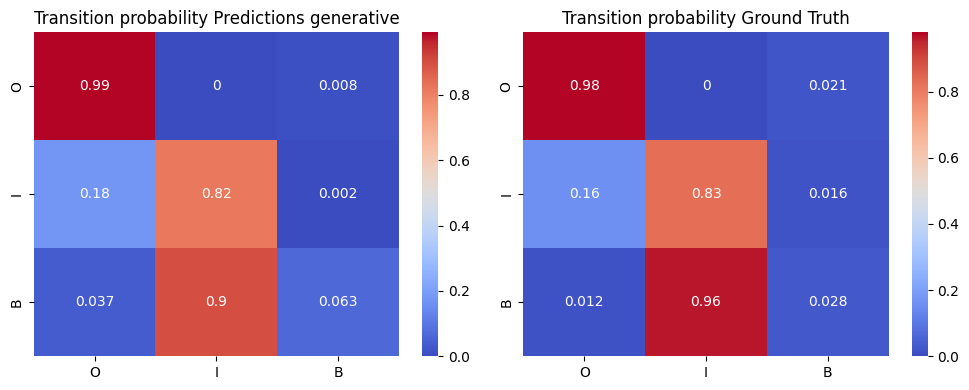

Transition Matrix from-to IOB labels 


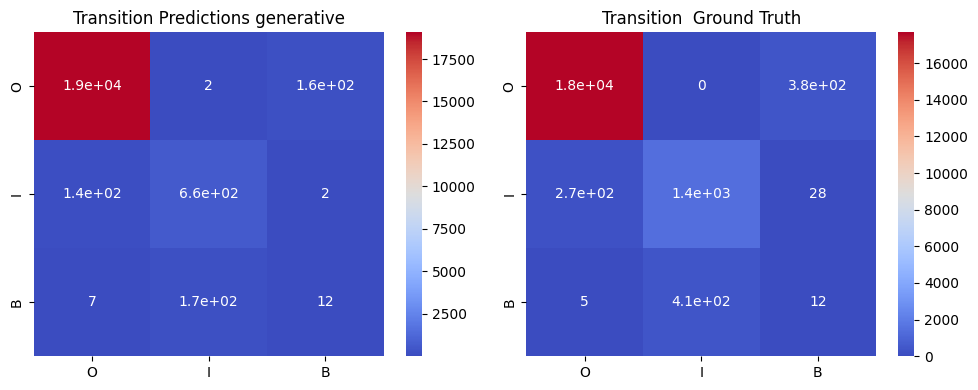

In [39]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

output_analist = OutputAnalist(data_parsed)
#output_analist.example_to_IOB(output_analist.data[19], 'model_output')
output_analist.data = output_analist.remove_allucinations_from_computation(output_analist.data)
output_analist.convert_to_IOB_tokenBased(tokenizer)
output_analist.create_evaluation_table_tkn(prediction_col_name='token_labels_response', ground_truth_col_name='token_labels_ground_truth')
display(output_analist.evaluation_table_tkn)
trans_matrix_pred = output_analist.get_transition_matrix('token_labels_response')
trans_matrix_gt = output_analist.get_transition_matrix('token_labels_ground_truth')

pred_df = pd.DataFrame(trans_matrix_pred['probability_matrix']).T
gt_df = pd.DataFrame(trans_matrix_gt['probability_matrix']).T
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(pred_df, annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title('Transition probability Predictions generative')
sns.heatmap(gt_df, annot=True, cmap="coolwarm", ax=axes[1])
axes[1].set_title('Transition probability Ground Truth')
print('Transition Matrix from-to IOB labels ')
plt.tight_layout()
plt.show()

pred_df = pd.DataFrame(trans_matrix_pred['transition_matrix']).T
gt_df = pd.DataFrame(trans_matrix_gt['transition_matrix']).T
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(pred_df, annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title('Transition Predictions generative')
sns.heatmap(gt_df, annot=True, cmap="coolwarm", ax=axes[1])
axes[1].set_title('Transition  Ground Truth')
print('Transition Matrix from-to IOB labels ')
plt.tight_layout()
plt.show()


Transition Matrix from-to IOB labels 


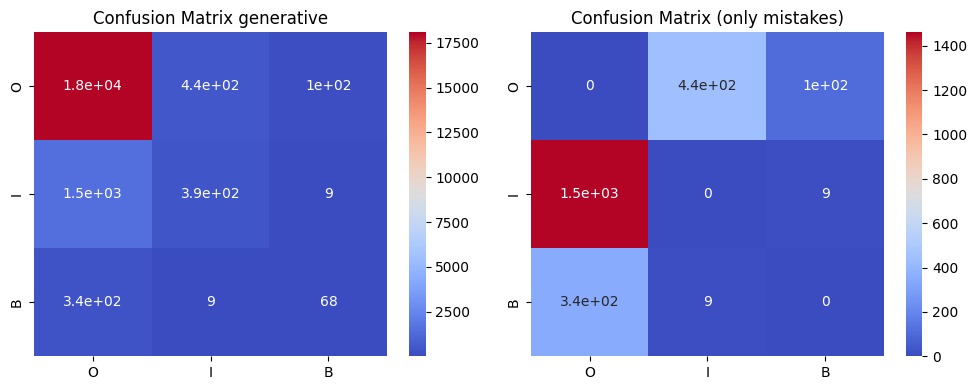

{'O': {'O': 18089, 'I': 444, 'B': 104},
 'I': {'O': 1460, 'I': 389, 'B': 9},
 'B': {'O': 344, 'I': 9, 'B': 68}}

In [40]:

confusion_matrix = output_analist.get_confusion_matrix(keep_diagonal=True)
confusion_matrix_no_diag = output_analist.get_confusion_matrix(keep_diagonal=False)

conf = pd.DataFrame(confusion_matrix).T
conf_no_diag = pd.DataFrame(confusion_matrix_no_diag).T
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(conf, annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title('Confusion Matrix generative')
sns.heatmap(conf_no_diag, annot=True, cmap="coolwarm", ax=axes[1])
axes[1].set_title('Confusion Matrix (only mistakes)')
print('Transition Matrix from-to IOB labels ')
plt.tight_layout()
plt.show()
confusion_matrix #{gt: {pred: count}}

## ALLUCINAZIONI

##### vediamo quante volte succede che il modello inventa entità che non son onel testo originario:

In [44]:
output_analist = OutputAnalist(data_parsed)

allucinations = []
for el in output_analist.data:
    invented_entities = []
    for extracted_entity in el['model_output_parsed']['entities']:
        if extracted_entity.lower() not in el['sentence'].lower():
            #print('EXTRACTED ENTITY NOT IN sentence: ', extracted_entity, '||||', el['sentence'])
            invented_entities.append(extracted_entity)
    allucinations.append(invented_entities)
len1 = len([el for sublist in allucinations for el in sublist])
len2 = len([el for sublist in output_analist.data['model_output_parsed'] for el in sublist['entities']])
print(f"There are {len1} invented entities over {len2} extracted entities -> {round(len1/len2*100,1)}%")

There are 4 invented entities over 714 extracted entities -> 0.6%


##### Quante di queste allucinazioni sono però molto simili a qualcosa che c'è nel testo?

In [45]:
data_with_all_col = output_analist.create_allucinations_columns(data_parsed, verbose = False)

len1 = len([el for sublist in allucinations for el in sublist])
len2 = len([el for sublist in data_with_all_col['heavy_allucinations'] for el in sublist])
print(f"There are {len2} heavy allucinations over {len1} allucinations -> {round(len2/len1*100,1)}%")
print(f"{len([sublist for sublist in data_with_all_col['heavy_allucinations'] if len(sublist)>0])} sentences are impacted by allucination out of 681 -> {round(len2/681*100,1)}%")


There are 1 heavy allucinations over 4 allucinations -> 25.0%
1 sentences are impacted by allucination out of 681 -> 0.1%


##### quando il modello è allucinato le performances peggiorano? Non solo quello è sbagliato, ma magari anche le altre fanno casino...

In [46]:
data_allucinated = data_with_all_col.filter(lambda x: len(x['heavy_allucinations'])>0)
evaluator_allucinations = Evaluator(data=data_allucinated, offset=False, output_cleaner=output_cleaner)
evaluator_allucinations.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, similarity_types=['case', 'subset', 'superset'])
evaluator_sentences_with_no_allucinations = Evaluator(data=data_with_all_col.filter(lambda x: len(x['heavy_allucinations'])==0), offset=False, output_cleaner=output_cleaner)
evaluator_sentences_with_no_allucinations.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, similarity_types=['case', 'subset', 'superset'])
print(f"NO allucinations -> f1:{evaluator_sentences_with_no_allucinations.evaluation_table['f1']} recall: {evaluator_sentences_with_no_allucinations.evaluation_table['recall']}, precision {evaluator_sentences_with_no_allucinations.evaluation_table['precision']}")
print(f"   allucinations -> f1:{evaluator_allucinations.evaluation_table['f1']} recall: {evaluator_allucinations.evaluation_table['recall']}, precision {evaluator_allucinations.evaluation_table['precision']}")

Filter:   0%|          | 0/681 [00:00<?, ? examples/s]

/home/pferrazzi/mistral_finetuning/utils/evaluator.py:529: RuntimeWarning: invalid value encountered in scalar divide
  recall = summary['TP'] / (summary['TP'] + summary['FN'])


Filter:   0%|          | 0/681 [00:00<?, ? examples/s]

NO allucinations -> f1:0.3483043079743355 recall: 0.2571041948579161, precision 0.5397727272727273
   allucinations -> f1:nan recall: nan, precision 0.0


##### cerchiamo di capire quale sia essere l'impatto delle allucinazioni, cioè cosa succede se le togliamo dal computo e laciamo il resto invariato. Per esempio, se le estratte sono 'Pietro' 'ferrazzi' e la frase originale è 'Pietro sta programmando', normalmente conteggio 'ferrazzi' come FP. Qui voglio vedere se escludendolo dal conteggio le performance sono comunque peggiori. In altre parole, voglio vedere se un'allucinazione ha l'effetto di modifcare anche quello che succede intorno ad essa.

Questo è il confronto tra avere allucinazioni e dopo averle tolte considerando soltanto le frasi per cui sono state generate allucinazioni

In [ ]:
output_analist = OutputAnalist(tmp)
data_allucinated_removed = output_analist.remove_allucinations_from_computation(data_allucinated)

evaluator_marginal_allucinations_removed = Evaluator(data_allucinated_removed, offset=False, output_cleaner=None)
evaluator_marginal_allucinations_removed.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, similarity_types=['case', 'subset', 'superset'], already_parsed_inputs=True)
print(f"allucinations removed -> f1:{evaluator_marginal_allucinations_removed.evaluation_table['f1']} recall: {evaluator_marginal_allucinations_removed.evaluation_table['recall']}, precision {evaluator_marginal_allucinations_removed.evaluation_table['precision']}")

evaluator_marginal_allucinations = Evaluator(data_allucinated, offset=False, output_cleaner=None)
evaluator_marginal_allucinations.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, similarity_types=['case', 'subset', 'superset'], already_parsed_inputs=False)
print(f"allucinations         -> f1:{evaluator_marginal_allucinations.evaluation_table['f1']} recall: {evaluator_marginal_allucinations.evaluation_table['recall']}, precision {evaluator_marginal_allucinations.evaluation_table['precision']}")

##### sembra che le allucinazioni rendano le performances leggermente peggiori, anche una volta che le marginallizzi

un allucinazione è un FP. 
H0: p( TN | allucinazione ) < p( TN | ! allucinazione)  [cioè, il fatto che ci siano delle allucinazioni è correlato alla miglior comprensione del contesto da parte del modello, che 'esagera' a generare positivi, ma non sbaglia più i negativi]


da qui si vede che in realtà non cambia molto -> le allucinazioni non sembrano impattare in maniera importante il resto del testo generato

In [ ]:
import matplotlib.pyplot as plt

summary_all_removed = evaluator_marginal_allucinations_removed.evaluation_table['evaluation'].sum() / evaluator_marginal_allucinations_removed.data.num_rows
summary_NO_all = evaluator_sentences_with_no_allucinations.evaluation_table['evaluation'].sum() / evaluator_sentences_with_no_allucinations.data.num_rows

fig, ax = plt.subplots()
labels = ['TP', 'FP', 'FN']
width = 0.35
x = range(len(labels))
rects1 = ax.bar(x, summary_all_removed, width, label='allucinations removed')
rects2 = ax.bar([i + width for i in x], summary_NO_all, width, label='NO all')
ax.set_ylabel('Count')
ax.set_title('TP, FP, FN (per sentence) for allucinated and non allucinated sentences')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()

##### Vediamo cosa succede se tolgo dalle entità estratte quelle allucinate, e valuto le performances come se il modello quelle non le avesse estratte

In [48]:
output_analist = OutputAnalist(data_parsed)
data_allucinated_removed_only_heavy = output_analist.remove_allucinations_from_computation(data_parsed, only_heavy=False)
data_allucinated_removed_light = output_analist.remove_allucinations_from_computation(data_parsed, only_heavy=True)


evaluator_light = Evaluator(data=data_allucinated_removed_light, offset=False, output_cleaner=None)
evaluator_light.generate_evaluation_table(similar_is_equal_threshold=100,
                                    words_level=True, 
                                    similarity_types=['case', 'subset', 'superset'],
                                    already_parsed_inputs=True,
                                    add_TP_FP_TN_FN_to_data=True)

evaluator_heavy =  Evaluator(data_allucinated_removed_only_heavy, offset=False, output_cleaner=None)
evaluator_heavy.generate_evaluation_table(similar_is_equal_threshold=100,
                                                                   words_level=True, 
                                                                   similarity_types=['case', 'subset', 'superset'], 
                                                                   already_parsed_inputs=True,
                                                                   add_TP_FP_TN_FN_to_data=True
                                                                   )
print(f"light allucinations removed -> f1:{evaluator_light.evaluation_table['f1']}")
print(f"heavy allucinations removed -> f1:{evaluator_heavy.evaluation_table['f1']} ")
print(f"no allucination removed     -> f1:{ evaluator.evaluation_table['f1']}")

light allucinations removed -> f1:0.6911910009880672
heavy allucinations removed -> f1:0.6885841981668055 
no allucination removed     -> f1:0.6870527980718536


## DUPLICAZIONI

##### guardiamo quante volte è successo che entità duplicate (perfect match) sono state estratte:

In [26]:
res = output_analist.count_repetitions_in_extraction()
print(f"n_duplicated_ent: {res['n_duplicated_ent']}, n_extracted_ent: {res['n_extracted_ent']}, n_extracted_deduplicated_ent: {res['n_extracted_deduplicated_ent']}\n the percentage of duplicated entities over the total of extracted is {round(res['n_duplicated_ent']/res['n_extracted_ent']*100,1)}%")

n_duplicated_ent: 0, n_extracted_ent: 714, n_extracted_deduplicated_ent: 714
 the percentage of duplicated entities over the total of extracted is 0.0%


## ERROR types

In [32]:
errors = output_analist.get_errors_shifts_extensions_reductions_holes(verbose=False, labels_gt_col_name='token_labels_ground_truth', labels_pred_col_name='token_labels_response')
errors_lenght = output_analist.get_errors_by_lenght( labels_gt_col_name='token_labels_ground_truth', labels_pred_col_name='token_labels_response')
display(errors['percentage'])
display(errors_lenght)

{'shifts': {'left': 0.01, 'right': 0.0},
 'extensions': 0.01,
 'reductions': 0.01,
 'holes': 0.0}

{'ent_length_3': {'total_number': 81, 'missclassified': 81},
 'ent_length_4': {'total_number': 62, 'missclassified': 62},
 'ent_length_5': {'total_number': 0, 'missclassified': 0},
 'ent_length_6': {'total_number': 46, 'missclassified': 46}}

## only generative

#### by word

In [42]:
errors = output_analist.get_errors_shifts_extensions_reductions_holes(verbose=True, labels_gt_col_name='word_labels_ground_truth', labels_pred_col_name='word_labels_response')
display(errors['percentage'])


REDUCTION pos  9 tokens:   ophth
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I']
EXTENSION pos  2 tokens:  
['O', 'B', 'I', 'O', 'O', 'O', 'O']
['O', 'B', 'O', 'O', 'O', 'O', 'O']
SHIFT pos  7 tokens:  th day
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'B', 'O', 'B', 'B', 'I', 'I', 'O', 'B']
SHIFT pos  5 tokens:  CT sca
['O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
SHIFT pos  15 tokens:  , the 
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'B', 'I']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'B']
EX

{'shifts': {'left': 0.04, 'right': 0.0},
 'extensions': 0.01,
 'reductions': 0.01,
 'holes': 0.0}

## JOINT ANALYSIS with seq2seq

In [10]:
from datasets import load_dataset
checkpoint = "ferrazzipietro/LS_Llama-best"
data_seq2seq = load_dataset(checkpoint, split="test")

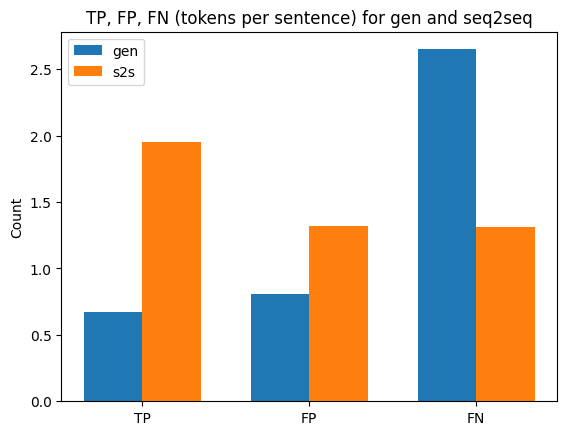

In [13]:
import matplotlib.pyplot as plt

summary_gen = output_analist.data.to_pandas()[['TP', 'FP', 'FN']].sum() / output_analist.data.num_rows
summary_seq2seq = data_seq2seq.to_pandas()[['TP', 'FP', 'FN']].sum() / data_seq2seq.num_rows

fig, ax = plt.subplots()
labels = ['TP', 'FP', 'FN']
width = 0.35
x = range(len(labels))
rects1 = ax.bar(x, summary_gen, width, label='gen')
rects2 = ax.bar([i + width for i in x], summary_seq2seq, width, label='s2s')
ax.set_ylabel('Count')
ax.set_title('TP, FP, FN (tokens per sentence) for gen and seq2seq')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()